# Characterize the Transport Mechanisms 

In [2]:
import cartopy
import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal

%matplotlib widget

In [3]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

def latlon_to_local(lat, lon, lat_0, lon_0):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

    #Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))
    x, y = proj.transform(crs_wgs, cust, lon, lat)
    return x, y

In [4]:
# Add the wave gliders back in
df = pd.read_csv('../data/play1_df.csv')
df = df.dropna(subset=['hs'])
df.head()

# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])
ice_concentration = ice_map_conc[:,:,ind_for_ice_map]

# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_concentration.shape)
ice_conc_15percent[ice_concentration >= 15] = 1

# Define the Local Cartesian Coordinate System
lat_0 = 72.48
lon_0 = -151.1

# Convert Lat lon on Ice Map to cartesian system 
x_icemap, y_icemap = latlon_to_local(ice_map_lat, ice_map_lon, lat_0, lon_0)

# Convert the SWIFT Track Coordinates to the local Cartesian system
x_swifts_gliders, y_swifts_gliders = latlon_to_local(df['latitude'], df['longitude'], lat_0, lon_0)

# Get time values for the SWIFTs
time_swifts = df['time'][:]

# Find the x and y location of the 15% ice concentration
# Find the 15% concentration contour line
ice_edge_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]

ice_edge_contour_lat_vals = []

for n in range(ice_conc_15percent.shape[0]):
    ice_edge_lat_index_array = np.where(ice_conc_15percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_contour_lat_vals.append(np.NaN)

# Convert lon values to numpy array
ice_edge_contour_lat_vals = np.array(ice_edge_contour_lat_vals)

# Convert the ice edge values to cartesian and polar coordinates
x_iceedge, y_iceedge = latlon_to_local(ice_edge_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)

# Interpolate the x and y ice edge values to make a smooth curve of the ice edge
x_iceedge_interp = np.linspace(-60000, 150000, num=50000)
y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)

fs = 1 / (x_iceedge_interp[1] - x_iceedge_interp[0])
cutoff = 1/40000
order = 1
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
y_iceedge_smoothed = signal.filtfilt(b, a, y_iceedge_interp)

2022-09-10 00:00:00


/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_31365/1325526485.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://p

(50000,)


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_31365/3811410834.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,


Text(0, 0.5, 'Y [m]')

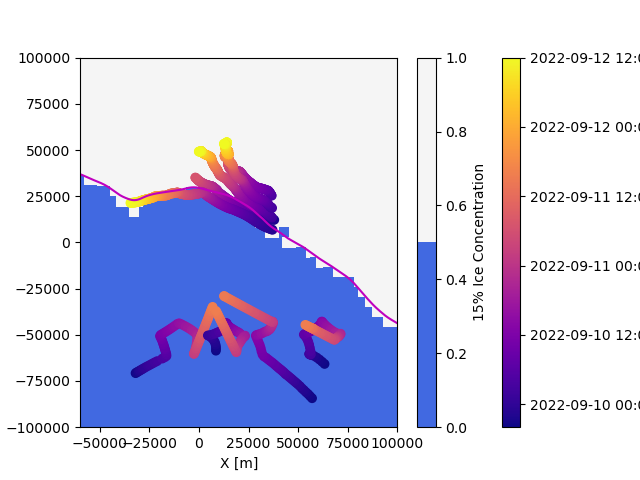

In [5]:
datetimes = pd.to_datetime(time_swifts)

# Convert datetime objects to numerical values (Matplotlib dates)
date_numbers = np.squeeze(mdates.date2num(datetimes))
date_numbers.shape
print(x_iceedge_interp.shape)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
im3 = ax.scatter(x_swifts_gliders, y_swifts_gliders, c=date_numbers, cmap='plasma')
cbar2 = fig.colorbar(im3)
cbar2.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,
                    cmap=cmap, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('15% Ice Concentration')
ax.set_xlim(-60000, 100000)
ax.set_ylim(-100000, 100000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

129.48148753118673
-39.48148753118673
68.32611558326063
21.67388441673937
129.48148753118673


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_31365/2136485174.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,


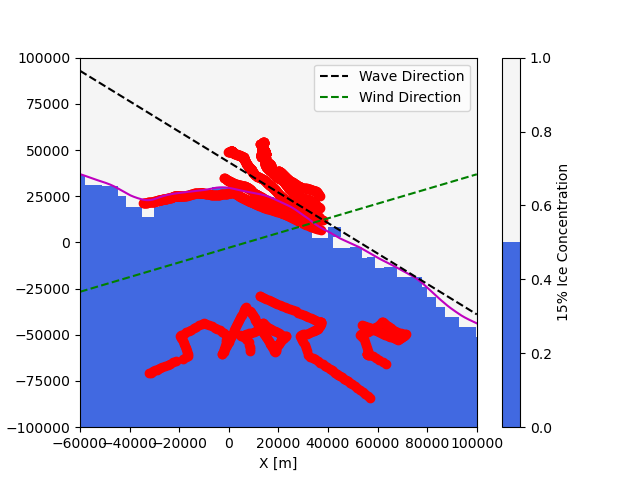

In [6]:
# Plot One SWIFT Point and draw a line at this angle compared to the ice edge
# Plot One SWIFT Point and draw a line at this angle compared to the ice edge
x_val = x_swifts_gliders[0]
y_val = y_swifts_gliders[0]
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir)
mean_wave_dir_mathconv = 90 - mean_wave_dir
print(mean_wave_dir_mathconv)
slope = np.tan(np.deg2rad(mean_wave_dir_mathconv))
intercept = y_val - slope*x_val
x_vals = x_iceedge_interp
y_vals = slope*x_vals + intercept

mean_wind_dir = np.mean(df['winddir'])
mean_wind_dir_mathconv = 90 - mean_wind_dir
print(mean_wind_dir)
print(mean_wind_dir_mathconv)
slope_wind = np.tan(np.deg2rad(mean_wind_dir_mathconv))
intercept_wind = y_val - slope_wind*x_val
x_vals = x_iceedge_interp
y_vals_wind = slope_wind*x_vals + intercept_wind

print(mean_wave_dir)

# Plot with all the SWIFT tracks
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
ax.plot(x_vals, y_vals, color='k', linestyle='dashed', label='Wave Direction')
ax.plot(x_vals, y_vals_wind, color='g', linestyle='dashed', label='Wind Direction')
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,
                    cmap=cmap, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('15% Ice Concentration')
ax.scatter(x_swifts_gliders, y_swifts_gliders, color='r')
ax.set_xlim(-60000, 100000)
ax.set_ylim(-100000, 100000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()

Max Wind Transport Magnitude: 0.1538492965698242 m/s
Min Wind Transport Magnitude: 0.016058800220489503 m/s


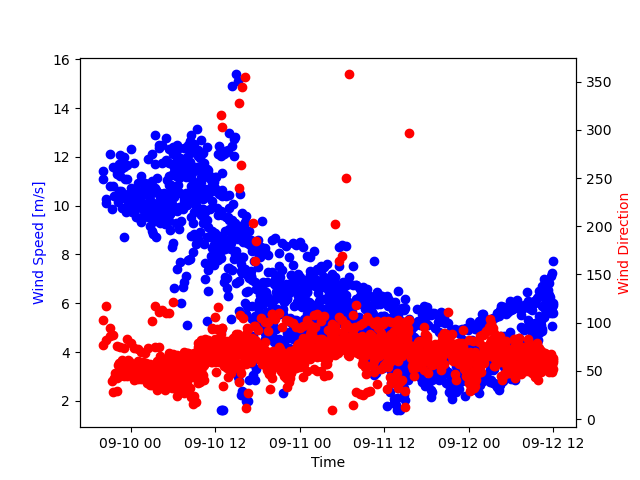

In [7]:
# Compute Magnitude of Wind Driven Transport
mean_wind_speed = np.mean(df['windspd'])
fig, ax = plt.subplots()
ax.scatter(datetimes, df['windspd'], color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed [m/s]', color='blue')
ax2 = ax.twinx()
ax2.scatter(datetimes, df['winddir'], color='r')
ax2.set_ylabel('Wind Direction', color='r')

# Compute Wind Transport Magnitude Range
print(f"Max Wind Transport Magnitude: {np.max(df['windspd'])* 0.01} m/s")
print(f"Min Wind Transport Magnitude: {np.min(df['windspd'])* 0.01} m/s")

Text(0, 0.5, 'Wind Stress, [Pa]')

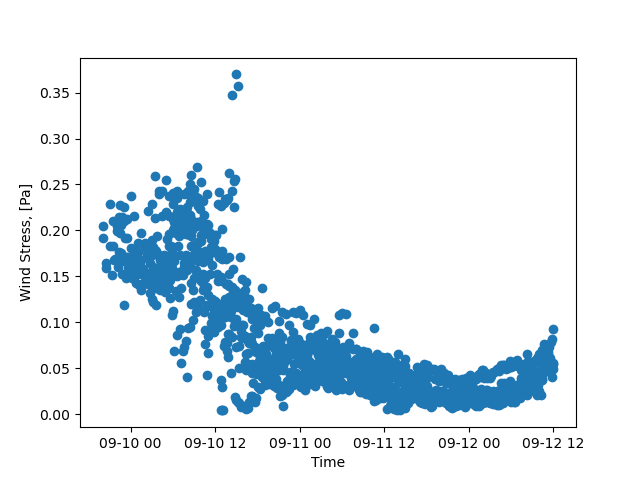

In [8]:
# Compute Ekman Transport Magnitude

# Compute the Wind stress 
rho = 1.25 # air density 
C_d = 0.00125 # drag coefficient
tau = rho * C_d * df['windspd']**2

fig, ax = plt.subplots()
ax.scatter(datetimes, tau)
ax.set_xlabel('Time')
ax.set_ylabel('Wind Stress, [Pa]')


Text(0, 0.5, 'Wind Direction [rad]')

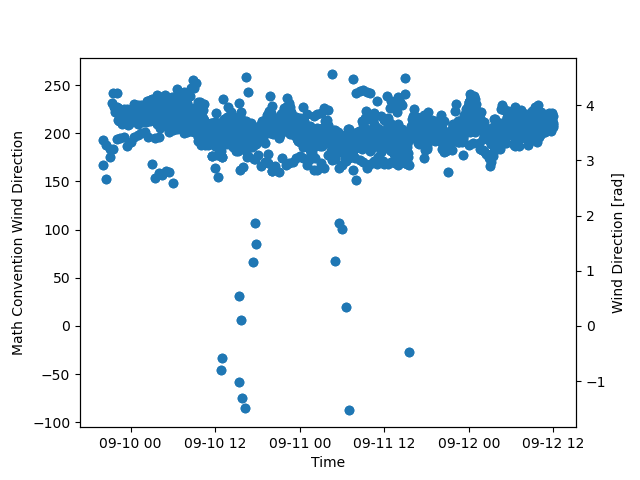

In [9]:
# Compute the Components of the Wind Stress 
wind_direction_math_conv = 270 - df['winddir']
wind_direction_rad = np.deg2rad(wind_direction_math_conv)

fig, ax = plt.subplots()
ax.scatter(datetimes, wind_direction_math_conv)
ax.set_xlabel('Time')
ax.set_ylabel('Math Convention Wind Direction')
ax2 = ax.twinx()
ax2.scatter(datetimes, wind_direction_rad)
ax2.set_ylabel('Wind Direction [rad]')

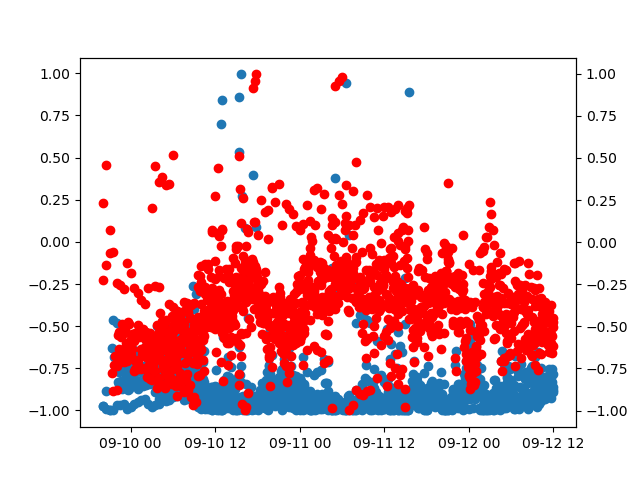

In [10]:
# Compute x and y components
x_angle_mag = np.cos(wind_direction_rad)
y_angle_mag = np.sin(wind_direction_rad)

fig, ax = plt.subplots()
ax.scatter(datetimes, x_angle_mag)
ax2 = ax.twinx()
ax2.scatter(datetimes, y_angle_mag, color='r')

Text(0, 0.5, 'NS (Y) Wind Stress [Pa]')

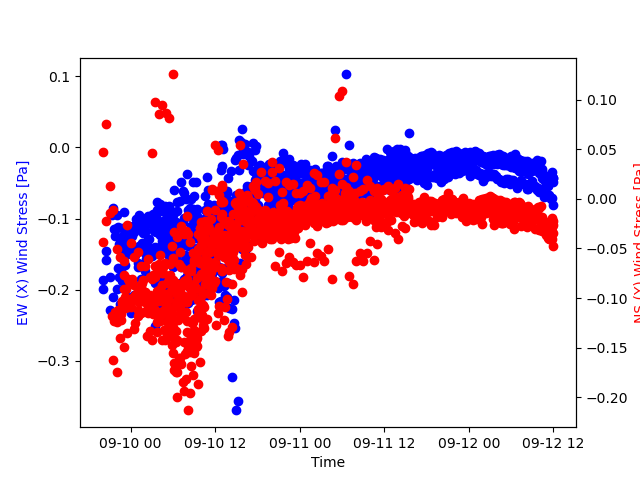

In [11]:
# Compute Components of Wind Stress
tau_x = tau * x_angle_mag
tau_y = tau * y_angle_mag

fig, ax = plt.subplots()
ax.scatter(datetimes, tau_x, color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('EW (X) Wind Stress [Pa]', color='blue')
ax2 = ax.twinx()
ax2.scatter(datetimes, tau_y, color='r')
ax2.set_ylabel('NS (Y) Wind Stress [Pa]', color='r')

72.61576508704755
0.00013880059205891222
0.35144293753569694


Text(0, 0.5, 'NS (Y) Ekman Velocity [m/s]')

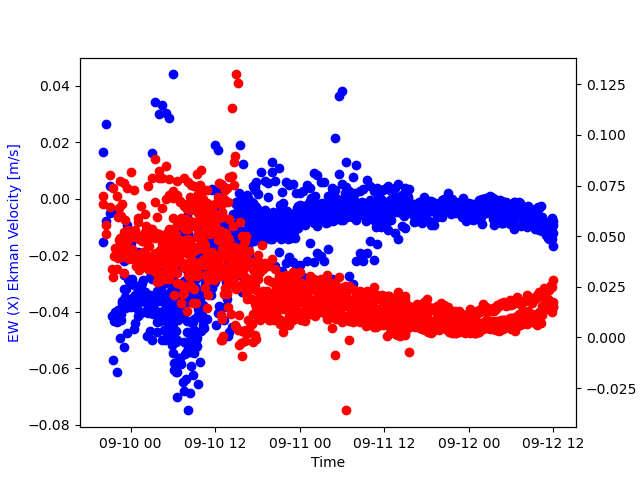

In [12]:
# Compute Ekman Transport Components
D_e = 20 # Depth of Ekman layer in meters, from Hunkins, 1966; Yang, 2006 but I got it from Ma et al 2017
mean_latitude = np.mean(df['latitude'])
print(mean_latitude)
rho_water = 1025 # kg/m^3 - could compute density from salinity and temperature measurements
f = 2 * (2 * np.pi / (24 * 60 * 60)) * np.sin(np.deg2rad(mean_latitude)) # Units of Hz
print(f)

print(1/(f * rho_water * D_e))

u_ekman = 1/(f * rho_water * D_e) * tau_y
v_ekman = -1/(f * rho_water * D_e) * tau_x

fig, ax = plt.subplots()
ax.scatter(datetimes, u_ekman, color='b')
ax.set_xlabel('Time')
ax.set_ylabel('EW (X) Ekman Velocity [m/s]', color='blue')
ax2 = ax.twinx()
ax2.scatter(datetimes, v_ekman, color='r')
ax2.set_ylabel('NS (Y) Ekman Velocity [m/s]', color='r')

Max Ekman Magnitude = 0.12997681066081826
Min Ekman Magnitude = 0.0014161231972195567


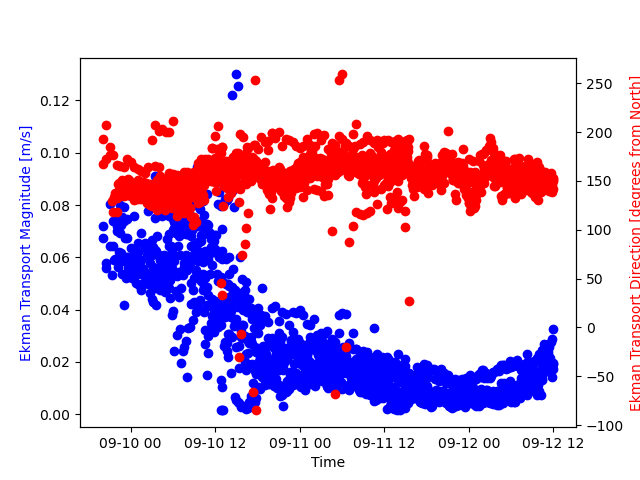

In [13]:
# Compute Magnitude and direction of Ekman transport
ekman_magnitude = np.sqrt(u_ekman**2 + v_ekman**2)
ekman_direction_math_conv = np.rad2deg(np.arctan2(v_ekman, u_ekman)) % 360
ekman_direction_nautical = 270 - ekman_direction_math_conv

fig, ax = plt.subplots()
ax.scatter(datetimes, ekman_magnitude, color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Ekman Transport Magnitude [m/s]', color='b')
ax2 = ax.twinx()
ax2.scatter(datetimes, ekman_direction_nautical, color='r')
ax2.set_ylabel('Ekman Transport Direction [degrees from North]', color='r')

print(f'Max Ekman Magnitude = {np.max(ekman_magnitude)}')
print(f'Min Ekman Magnitude = {np.min(ekman_magnitude)}')

68.32611558326063
155.09751566611337


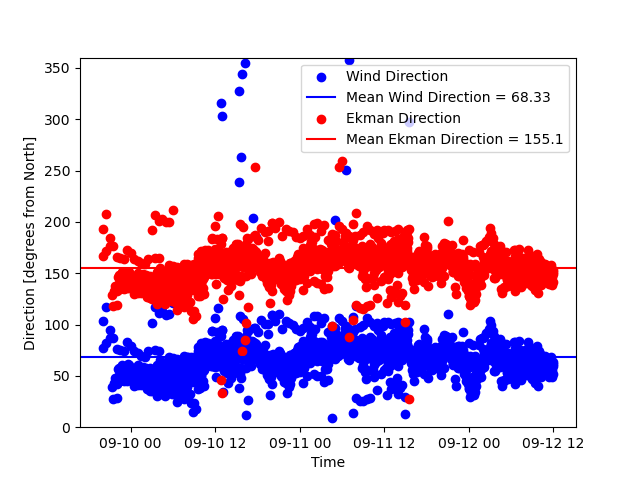

In [14]:
# Wind and Ekman direction sanity check
fig, ax = plt.subplots()
ax.scatter(datetimes, df['winddir']%360, color='b', label='Wind Direction')
mean_winddir = np.mean(df['winddir']%360)
ax.axhline(mean_winddir, color='b', label=f'Mean Wind Direction = {np.round(mean_wind_dir, 2)}')
ax.scatter(datetimes, ekman_direction_nautical, color='r', label='Ekman Direction')
ax.axhline(np.mean(ekman_direction_nautical), color='r', label=f'Mean Ekman Direction = {np.round(np.mean(ekman_direction_nautical), 2)}')
ax.set_ylabel('Direction [degrees from North]')
ax.set_xlabel('Time')
ax.set_ylim(0, 360)
ax.legend()

print(np.mean(df['winddir']%360))
print(np.mean(ekman_direction_nautical))

In [ ]:
# Recompute Ekman Velocity based on a depth dependence relationship


Max Stokes Magnitude = 3.025318638307313 m/s
Min Stokes magnitude = 4.8780045553827316e-05 m/s


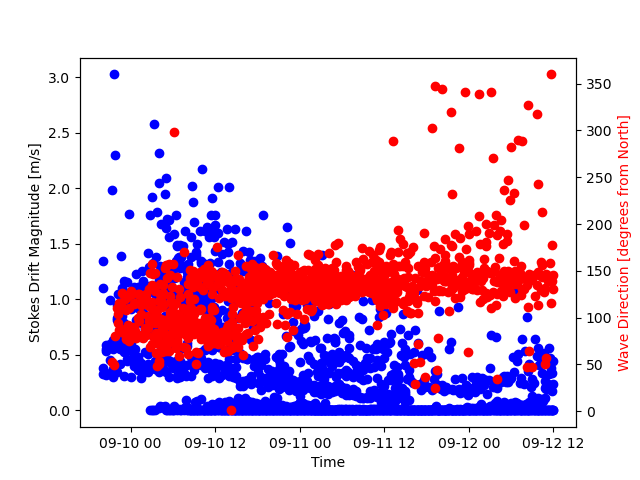

In [15]:
# Characterize Stokes Drift Magnitude
g = 9.8
u_stokes = ((2 * np.pi)**3 / g) * df['hs']**2 / df['wave_period']**3

fig, ax = plt.subplots()
ax.scatter(datetimes, u_stokes, color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Stokes Drift Magnitude [m/s]')
ax2 = ax.twinx()
ax2.scatter(datetimes, df['wave_direction'], color='r')
ax2.set_ylabel('Wave Direction [degrees from North]', color='r')

print(f'Max Stokes Magnitude = {np.max(u_stokes)} m/s')
print(f'Min Stokes magnitude = {np.min(u_stokes)} m/s')

3.025318638307313
1.946768045425415
0.9390746355056764
3.025318638307313


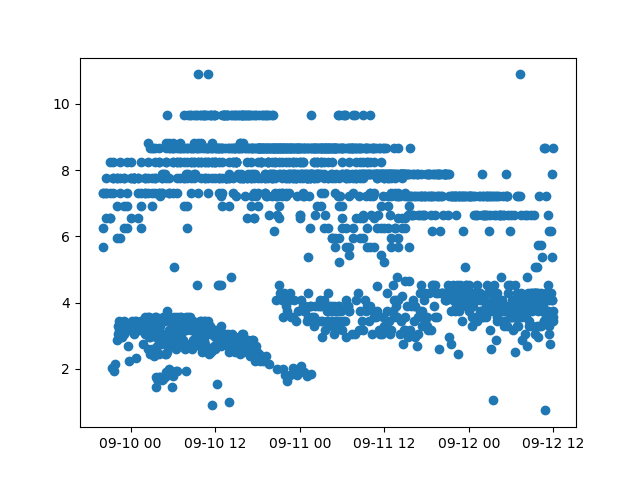

In [16]:
ind = np.argmax(u_stokes)
print(u_stokes[ind])
print(df['wave_period'].iloc[ind])
print(df['hs'].iloc[ind])

test = ((2 * np.pi)**3 / g) * df['hs'].iloc[ind]**2 / df['wave_period'].iloc[ind]**3
print(test)

fig, ax = plt.subplots()
ax.scatter(datetimes, df['wave_period'])

Text(0.5, 0, 'Time')

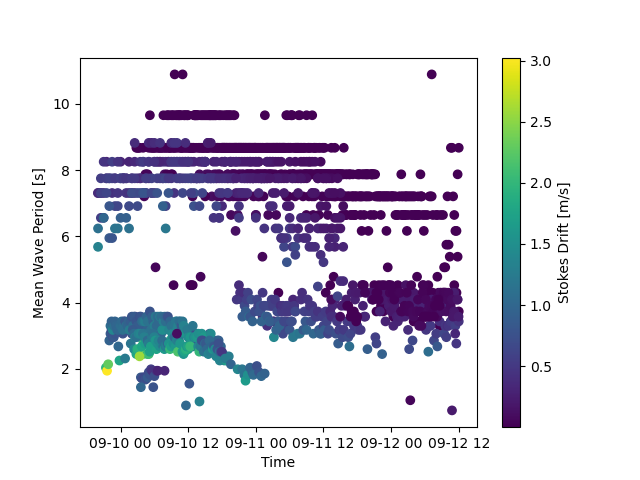

In [19]:
fig, ax = plt.subplots()
im = ax.scatter(datetimes, df['wave_period'], c=u_stokes)
cbar = plt.colorbar(im)
cbar.set_label('Stokes Drift [m/s]')
ax.set_ylabel('Mean Wave Period [s]')
ax.set_xlabel('Time')

Text(0.5, 0, 'Time')

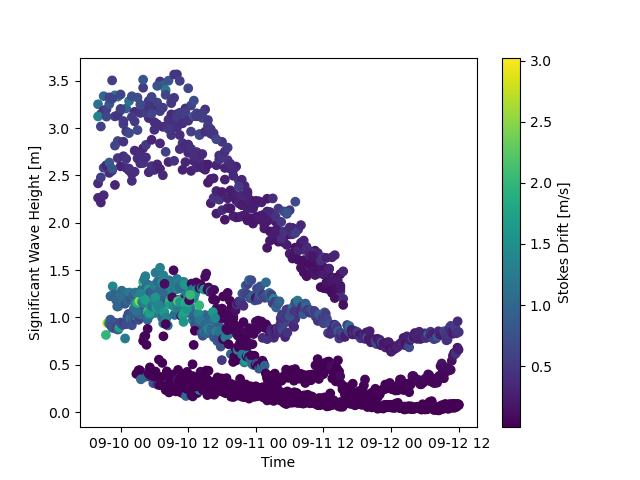

In [21]:
fig, ax = plt.subplots()
im = ax.scatter(datetimes, df['hs'], c=u_stokes)
cbar = plt.colorbar(im)
cbar.set_label('Stokes Drift [m/s]')
ax.set_ylabel('Significant Wave Height [m]')
ax.set_xlabel('Time')

In [24]:
# We should compute Stokes Drift Over the full Wave Spectrum Instead and see how that looks
(2*3.14)**3 / 9.8 * (1**2)/(2**3)

3.1590963265306122